In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## 전이학습
### 특성 추출

In [2]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms    #데이터 전처리 패키지
import torchvision.models as models            #다양한 파이토치 네트워크 사용
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
from torchvision.datasets import ImageFolder

In [4]:
# 로컬데이타 불러오기

data_path = '../CNN_simplock/sim_2/train'

# 이미지 데이터 변환하여 네트워크 입력으로 사용할 수 있게 변환    
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),      # 합성곱층을 통과하기 위해 크기 조정
                    transforms.RandomResizedCrop(224),   # 데이터 확장 용도, 랜덤한 비율로 자른 후 데이터 크기 조정
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])

# datasets.ImageFolder 데이터로더가 데이터를 불러올 대상과 방법을 정의
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

# 데이터로더는 앞서 정의한ImageFolder를 데이터로더에 할당
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    # batch_size=16,

    num_workers=8,
    shuffle=True
)


print(len(train_dataset))

305


In [5]:
# from torch.utils.data import Dataset, DataLoader

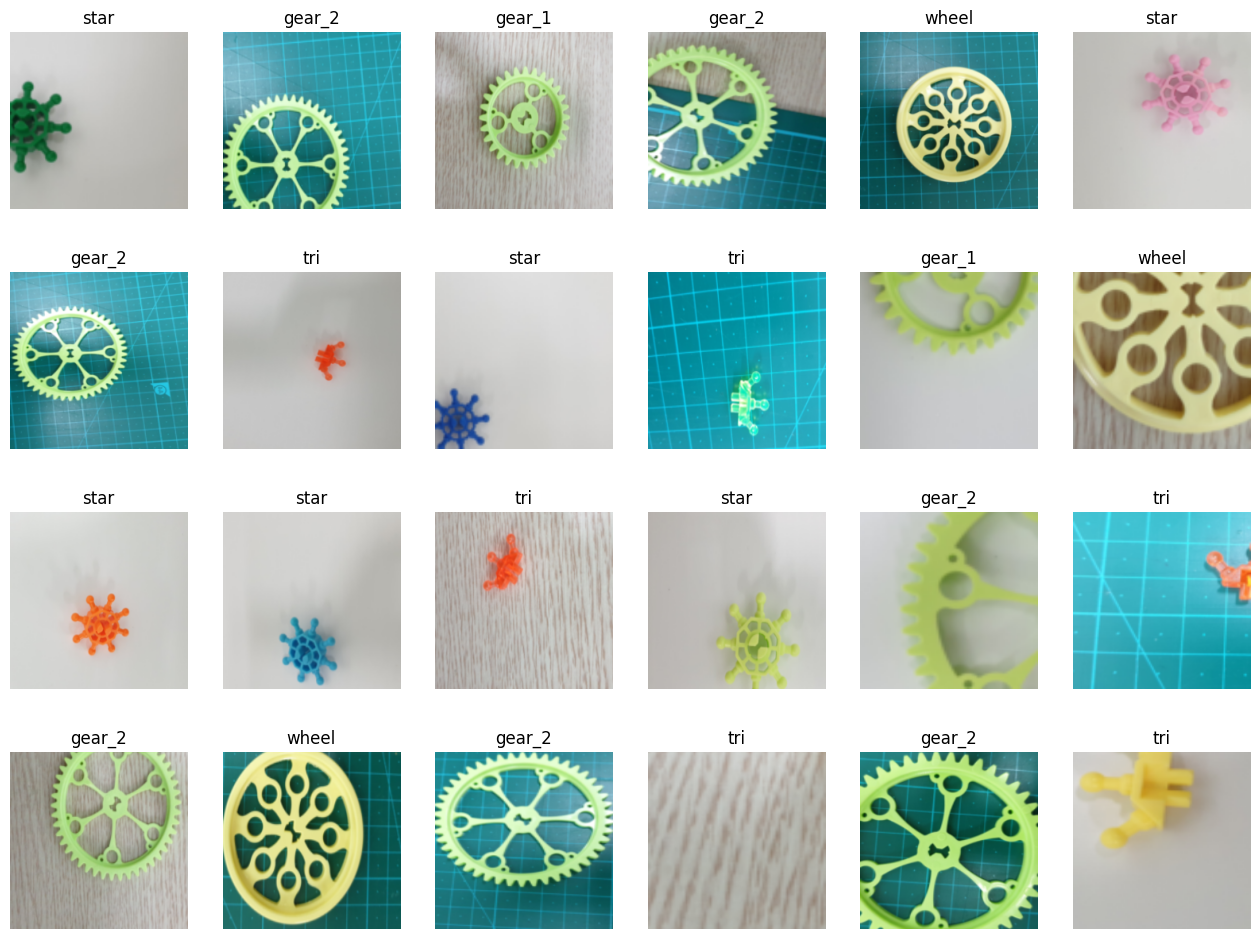

In [6]:
# 이미지에 대해 레이블 정보와 함께 출력
# 반복자(iterator, for 구문과 같은 효과)를 사용하려면 iter()와 next()가 필요.
# iter()는 전달된 데이터의 반복자를 꺼내 반환, next() 그 반복자가 다음에 출력해야 할 요소 반환
# 즉, iter()로 반복자를 구하고 그 반복자를 next()에 전달


# samples, labels = iter(train_loader).next()

samples, labels = next(iter(train_loader))
# 반복자는 train_loader, 따라서 tarin_loader에서 sample과 labels의 값을 순차적으로 꺼내 저장


classes = {0:'bebel', 1:'gear_1', 2:'gear_2', 3:'star', 4:'tri', 5:'wheel'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    # np.tarnspose는 행열 바꿈, 행렬의 내적 연산 때문에(행과 열의 수가 같아야 내적이 가능
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [7]:
# 사전 훈련된 resnet18 모델 내려받기, pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

resnet18 = models.resnet18(pretrained=True)

C:\Users\AI-space\anaconda3\envs\ve_torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\AI-space\anaconda3\envs\ve_torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# 내려받은 ResNet18의 합성곱층을 사용하된 파라미터에 대해서는 학습하지 않도록 고정

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False   # 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음
            
set_parameter_requires_grad(resnet18)

In [9]:
# ResNet18에 완전연결층 추가, 5는 클래스 갯수

resnet18.fc = nn.Linear(512, 6)

In [10]:
# 모델의 파라미터 값 확인
# 모델은 weight와 bias가 사용되고 있음.

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0301,  0.0280, -0.0440,  ..., -0.0276,  0.0224, -0.0294],
        [-0.0387, -0.0244,  0.0184,  ..., -0.0383,  0.0175, -0.0350],
        [ 0.0021, -0.0053, -0.0384,  ..., -0.0395,  0.0370,  0.0357],
        [ 0.0034, -0.0098, -0.0391,  ...,  0.0337,  0.0125,  0.0198],
        [-0.0067,  0.0132,  0.0269,  ..., -0.0038, -0.0091, -0.0105],
        [ 0.0284, -0.0005, -0.0060,  ..., -0.0386,  0.0339,  0.0344]])
fc.bias tensor([ 0.0348,  0.0095,  0.0353, -0.0358, -0.0394,  0.0405])


In [11]:
# 모델 학습 준비를 위해 모델 객체 생성, 손실 함수 정의

model = models.resnet18(pretrained = True)   # 모델 객체 생성

for param in model.parameters():             # 모델의 합성곱 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 6)
for param in model.fc.parameters():         # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()            # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

    
  데이터 준비 및 네트워크 생성 완료


In [12]:
# 모델 학습 진행

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=20, is_train=True):
    since = time.time()          #컴퓨터의 현재 시각    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):      #에폭 만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:         # 데이터로더에 전달된 데이터만큼 반복???
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()            # 기울기 0으로 설정
            outputs = model(inputs)          # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()                  # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)           # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)    # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset)             # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('../CNN_simplock/sim_2/', '{0:0=2d}.pth'.format(epoch)))    #모델 재사용을 위해 저장
        print()

    time_elapsed = time.time() - since          # 학습 시간 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history            # 모델의 정확도와 오차를 반환

In [13]:
# 완전연결층 학습, 학습하여 얻어지는 파라미터를 옵티마이저에 전달하여 최종적으로 모델 학습에 사용

params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)             # 파라미터 학습 결과를 저장
        print("\t",name)
            
# optimizer = optim.Adam(params_to_update) 원본        # 학습 결과를 옵티마이저에 전달
optimizer = torch.optim.Adam(resnet18.fc.parameters())   

	 fc.weight
	 fc.bias


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [15]:
criterion = nn.CrossEntropyLoss()      # 손실 함수 지정
# criterion = nn.CrossEntropyLoss(num_classes=5)

train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)


Epoch 0/19
----------
Loss: 1.6256 Acc: 0.3639

Epoch 1/19
----------
Loss: 1.1488 Acc: 0.6623

Epoch 2/19
----------
Loss: 0.8865 Acc: 0.7738

Epoch 3/19
----------
Loss: 0.7016 Acc: 0.8623

Epoch 4/19
----------
Loss: 0.5924 Acc: 0.8820

Epoch 5/19
----------
Loss: 0.5088 Acc: 0.9115

Epoch 6/19
----------
Loss: 0.4971 Acc: 0.9016

Epoch 7/19
----------
Loss: 0.4503 Acc: 0.9016

Epoch 8/19
----------
Loss: 0.4241 Acc: 0.9016

Epoch 9/19
----------
Loss: 0.4309 Acc: 0.9115

Epoch 10/19
----------
Loss: 0.3422 Acc: 0.9377

Epoch 11/19
----------
Loss: 0.3650 Acc: 0.9148

Epoch 12/19
----------
Loss: 0.3439 Acc: 0.9279

Epoch 13/19
----------
Loss: 0.2809 Acc: 0.9541

Epoch 14/19
----------
Loss: 0.3158 Acc: 0.9148

Epoch 15/19
----------
Loss: 0.3193 Acc: 0.9180

Epoch 16/19
----------
Loss: 0.2538 Acc: 0.9541

Epoch 17/19
----------
Loss: 0.2776 Acc: 0.9443

Epoch 18/19
----------
Loss: 0.2684 Acc: 0.9508

Epoch 19/19
----------
Loss: 0.2658 Acc: 0.9279

Training complete in 2m 23s
Be

In [16]:
# 테스트 용도의 데이터를 이용하여 모델 정확도 측정

test_path = '../CNN_simplock/sim_2/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

22


In [17]:
# 테스트 평가를 위한 함수 생성

def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../CNN_simplock/sim_2/' + '*.pth') # glob은 현재 디렉터리에서 원하는 파일들만 추출하여 가져옴. pth확장자는 모델을 훈련시킬 때 생성된 훈련 데이터 파일
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:     # 테스트 반복
        # for inputs, labels in iter(dataloaders):     # 테스트 반복
    
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():             # autograd 사용하지 않음
                outputs = model(inputs)       # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1)           # torch.max는 주어진 텐서 배열의 최댓값이 들어있는 index 반환
            preds[preds >= 0.5] = 1                    # torch.max로 출력된 값이 0.5보다 크면 바르게 예측
            preds[preds < 0.5] = 0                     # torch.max가 0.5보다 작으면 틀린 예측
            # running_corrects += preds.eq(labels.cpu()).int().sum()       # preds 배열과 labels가 일치하는지 검사. 일치하는 개수를 숫자로 출력
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history         # 계산된 정확도 반환

In [18]:
#테스트 데이터를 평가 함수에 적용

val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['../CNN_simplock/sim_2\\00.pth', '../CNN_simplock/sim_2\\01.pth', '../CNN_simplock/sim_2\\02.pth', '../CNN_simplock/sim_2\\03.pth', '../CNN_simplock/sim_2\\04.pth', '../CNN_simplock/sim_2\\05.pth', '../CNN_simplock/sim_2\\06.pth', '../CNN_simplock/sim_2\\07.pth', '../CNN_simplock/sim_2\\08.pth', '../CNN_simplock/sim_2\\09.pth', '../CNN_simplock/sim_2\\10.pth', '../CNN_simplock/sim_2\\11.pth', '../CNN_simplock/sim_2\\12.pth', '../CNN_simplock/sim_2\\13.pth', '../CNN_simplock/sim_2\\14.pth', '../CNN_simplock/sim_2\\15.pth', '../CNN_simplock/sim_2\\16.pth', '../CNN_simplock/sim_2\\17.pth', '../CNN_simplock/sim_2\\18.pth', '../CNN_simplock/sim_2\\19.pth']
Loading model ../CNN_simplock/sim_2\00.pth
Acc: 0.0909

Loading model ../CNN_simplock/sim_2\01.pth
Acc: 0.1364

Loading model ../CNN_simplock/sim_2\02.pth
Acc: 0.1818

Loading model ../CNN_simplock/sim_2\03.pth
Acc: 0.1818

Loading model ../CNN_simplock/sim_2\04.pth
Acc: 0.2273

Loading model ../CNN_simplock/sim_2\05.pth
Acc:

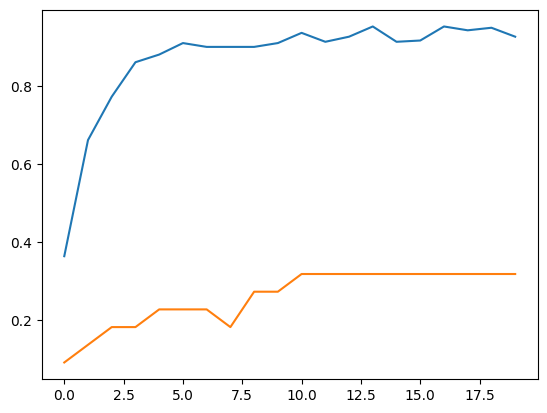

In [19]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인

plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

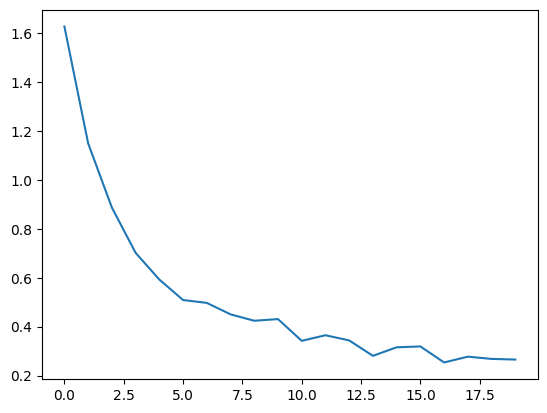

In [20]:
# 훈련 데이터의 오차에 대한 그래프 확인

plt.plot(train_loss_hist)
plt.show()

In [21]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):  
    image=tensor.clone().detach().numpy()    # 기존 텐서의 내용을 복사한 텐서 생성, detach는 기존 텐서에서 기울기가 전파되지 않는 텐서 즉, 기존 텐서를 복사하지만 기울기에 영향을 주지 않겠다.  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

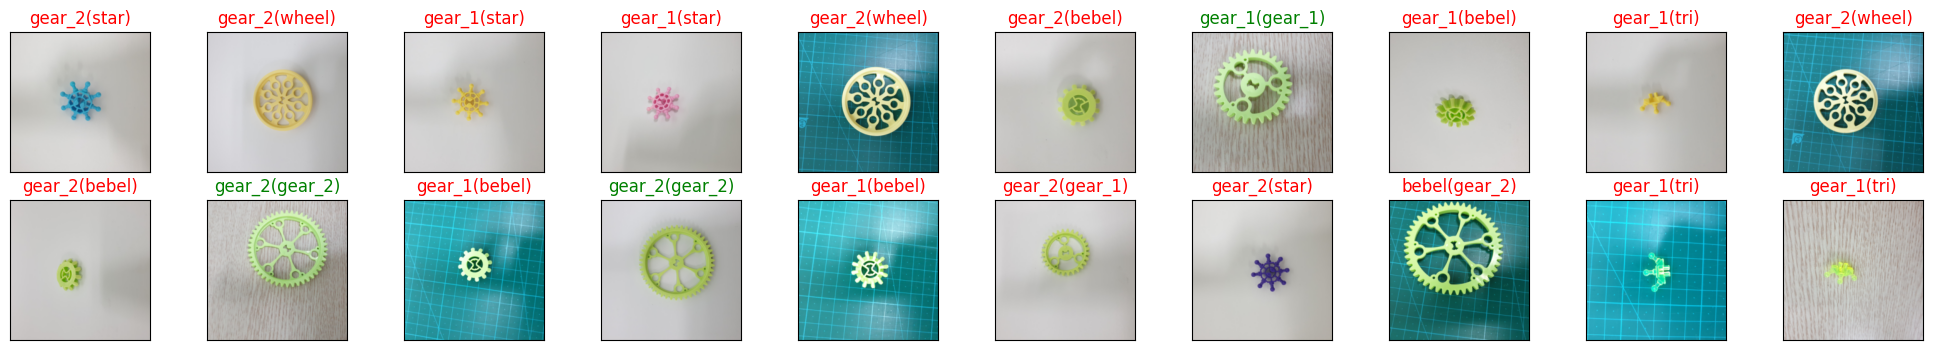

<Figure size 640x480 with 0 Axes>

In [22]:
# 테스트셋 이용 예측결과 출력

classes = {0:'bebel', 1:'gear_1', 2:'gear_2', 3:'star', 4:'tri', 5:'wheel'}

dataiter=iter(test_loader)     # 테스트 데이터셋 가져옴
images,labels=dataiter.__next__()      # 이미지와 레이블 분리하여 가져옴
# images,labels=dataiter.next() 
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  # add.subplot는 여러개의 이미지를 한 화면에 담는 코드, x,y축 삭제
    # plt.imshow(im_convert(images[i]))
    plt.imshow(im_convert(images[idx]))                 # 이미지 출력 im_convert 함수 적용
    a.set_title(classes[labels[idx].item()])          
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  #클래스 정의 된 값으로 판별하겠다. 
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)